In [1]:
import warnings
warnings.filterwarnings("ignore")
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from scipy import stats
import matplotlib as mpl
from textwrap import wrap
mpl.rcParams["font.family"] = "Times New Roman"
mpl.rcParams["font.sans-serif"] = "Times New Roman"
mpl.rcParams["font.size"] = 14
viridis_colors=['#440154', '#414487', '#2a788e', '#22a884', '#7ad151', '#fde725']

In [2]:
def same_dist_hypothesis(x,y, x_Name="first array", y_Name="second array", to_be_printed="both", p_check=0.05):
    """
    Arguments
    ---------
    x             : array like
                    First array
                    
    y             : array like
                    Second array

    p_check       : float
                    p-Value used for check
    
    x_Name        : string
                    Name of the x array, used for printing
    
    y_Name        : string
                    Name of the x array, used for printing

    to_be_printed : "both", "reject", "fail_to_reject"
                    Print the result in cases
    Returns
    -------
    result        : boolean
                    Whether we fail to reject the hypothesis (True if we fail to reject, False if we reject)
                            
    """

    if len(x) > 0 and len(y) > 0:
        _, p_value_ks= stats.kstest(x, y)
        _, p_value_levene= stats.levene(x, y)
        if(p_value_ks< p_check or p_value_levene< p_check):
            if to_be_printed=="both" or to_be_printed=="reject":
                print('Reject the hypothesis that', x_Name, 'and', y_Name, 'follow the same distribution')
            return False
        else:
            if to_be_printed=="both" or to_be_printed=="fail_to_reject":
                print('Fail to reject the hypothesis that', x_Name, 'and', y_Name, 'follow the same distribution')
                return True
    else:
        print('Test can not be conducted for', x_Name, 'and', y_Name,' because one of the arrays is empty')
        return True


In [3]:
factor_explored = 'ChamberPriority'

In [4]:
def read_and_merged(merged_df, base_path, file_name, xlsx_name, columns_of_interest, aggregate_with = "mean"):
    file_path = base_path + file_name + '/' + xlsx_name + '.xlsx'
    datafile =  pd.read_excel(file_path)
    if aggregate_with=="mean":
        datafile = datafile.groupby("Replication Id")[columns_of_interest].mean().reset_index()
    elif aggregate_with=="sum":
        datafile = datafile.groupby("Replication Id")[columns_of_interest].sum().reset_index()
    merged_df = pd.merge(merged_df, datafile, on=['Replication Id'], how='right')
    return merged_df

In [5]:
merged_dfs = []
run_length = 28 #days
no_chambers = 3
periodic_duration = 2 #hours
chamber_prio_list = ['Area', 'Availability', 'Custom', 'Utilisation']


base_folder_path = "data/Experiments/UnivariateAnalysis/"

for i, fleet_mix in enumerate(['IMA_AlternativeFleetMix']): # enumerate(['AlternativeFleetMix', 'IMA_AlternativeFleetMix']):
    for j, chamber_prio in enumerate(chamber_prio_list):
        # base_path = "Data/Experiments/Screening/"
        base_folder_path 
        regime = '40_80_10'
        base_path = base_folder_path + factor_explored + '/' + chamber_prio


        input_file_path = base_path + '/Scenario Parameters.xlsx'
        input_df =  pd.read_excel(input_file_path, index_col=0)
        no_set_per_file = len(input_df)
        input_df['FleetMix'] = fleet_mix
        input_df['LockingRegime'] = regime
        input_df['ChamberPriority'] = chamber_prio

        kpi_file_path = base_path + '/KPI Locks Summary.xlsx'
        kpi_df =  pd.read_excel(kpi_file_path, index_col=0)
        kpi_df['SetNo'] = 1 + (kpi_df.index -1) % no_set_per_file

        # Adding Emission calculation to kpi_df
        file_path = base_path + '/KPI Emissions Locks.xlsx'
        datafile =  pd.read_excel(file_path)
        datafile = datafile[datafile["Emission substance"]== "CO2"].loc[:,["Replication Id", "Emissions slowsteaming (kg/day)"]]
        kpi_df = pd.merge(kpi_df, datafile, on=['Replication Id'], how='right')

        # Merging these two dataframes
        merged_df = pd.merge(input_df, kpi_df, on=['SetNo'], how='right')

        merged_df['GlobalSetNo'] = merged_df['SetNo'] + i*no_set_per_file*(len(chamber_prio_list))
        merged_dfs.append(merged_df)

experiments = pd.concat(merged_dfs)
# del(merged_dfs)
experiments.describe()

,SetNo,TrafficRange,FleetIntensity,FlutteringProbability,MTTR,SlowDownEffect,MeanSlowDownCounter,PeriodicInspection,InspectionStart,InspectionDuration,...,Max number of ships waiting,Avg passage time (minutes),Avg waiting time (minutes),Service Level (%),Total Waiting Time (hours),Total Leveling Time (hours),Avg ships per leveling,Avg ships per filled leveling,Emissions slowsteaming (kg/day),GlobalSetNo
count,40.0,40.0,40.0,4.000000e+01,40.0,4.000000e+01,40.0,40.0,40.0,40.0,...,40.000000,40.000000,40.000000,40.000000,40.000000,40.000000,40.000000,40.000000,40.000000,40.0
mean,1.0,1.5,0.0,1.500000e-02,2.0,1.666667e-01,1120.0,28.0,8.0,2.0,...,33.975000,48.854689,29.094927,60.363520,4270.038207,2899.977385,2.682557,2.851850,39497.641996,1.0
std,0.0,0.0,0.0,1.054094e-17,0.0,8.432749e-17,0.0,0.0,0.0,0.0,...,8.489775,1.427859,1.262261,3.152517,185.395438,41.283372,0.033100,0.034862,1181.031212,0.0
min,1.0,1.5,0.0,1.500000e-02,2.0,1.666667e-01,1120.0,28.0,8.0,2.0,...,25.000000,45.803664,26.353125,55.473541,3867.321121,2835.017382,2.622169,2.786958,37132.989248,1.0
25%,1.0,1.5,0.0,1.500000e-02,2.0,1.666667e-01,1120.0,28.0,8.0,2.0,...,29.000000,48.167680,28.353369,57.748675,4159.201686,2869.824130,2.658869,2.822313,38882.440248,1.0
50%,1.0,1.5,0.0,1.500000e-02,2.0,1.666667e-01,1120.0,28.0,8.0,2.0,...,32.000000,48.764808,29.093205,59.869670,4272.094496,2893.838612,2.685841,2.850372,39427.163590,1.0
75%,1.0,1.5,0.0,1.500000e-02,2.0,1.666667e-01,1120.0,28.0,8.0,2.0,...,38.000000,49.547964,29.846412,62.938014,4380.208813,2921.504316,2.707596,2.878566,40244.691021,1.0
max,1.0,1.5,0.0,1.500000e-02,2.0,1.666667e-01,1120.0,28.0,8.0,2.0,...,67.000000,53.359723,32.811490,66.996025,4815.086153,3015.453144,2.756892,2.937250,43263.519505,1.0


In [6]:
experiments.columns

Index(['SetNo', 'TrafficRange', 'FleetIntensity', 'FlutteringProbability',
       'MTTR', 'SlowDownEffect', 'MeanSlowDownCounter', 'PeriodicInspection',
       'InspectionStart', 'InspectionDuration', 'FleetMix', 'LockingRegime',
       'ChamberPriority', 'Replication Id', 'Lock', 'Amount of ships',
       'Amount of levelings', 'Amount of empty levelings (%)',
       'Avg Occupancy (%)', 'Max number of ships waiting',
       'Avg passage time (minutes)', 'Avg waiting time (minutes)',
       'Service Level (%)', 'Total Waiting Time (hours)',
       'Total Leveling Time (hours)', 'Avg ships per leveling',
       'Avg ships per filled leveling', 'Emissions slowsteaming (kg/day)',
       'GlobalSetNo'],
      dtype='object')

In [7]:
experiments['LockCondition'] = experiments.apply(lambda x: 
                                           '0_control' if ((x['FlutteringProbability']==0) and (x['SlowDownEffect']==0))
                                           else('1_fluttering_only' if ((x['FlutteringProbability']==0.015) and (x['SlowDownEffect']==0))
                                                else '2_slowdown_only' if ((x['FlutteringProbability']==0) and (x['SlowDownEffect']!=0))
                                                else '3_both' if (x['FlutteringProbability']==0.015) else 
                                                '4_extreme' if (x['FlutteringProbability']==0.03) else 'faulty'), axis=1)

In [8]:
experiments['Avg lockage time (minutes)'] = 60*experiments['Total Leveling Time (hours)']/experiments['Amount of ships']
experiments.rename(columns={
    'Amount of ships':'Number of ships',
    'Amount of levelings' : 'Number of levelings',
    'Amount of empty levelings (%)' : 'Number of empty levelings (%)',
    'Emissions slowsteaming (kg/day)' : 'CO2 emissions (kg/day)',
    }, inplace=True)

In [9]:
cols_KPIs = ['CO2 emissions (kg/day)',
    'Avg lockage time (minutes)',
    'Avg waiting time (minutes)',
    'Number of levelings']
# To discuss in relation with 'Avg waiting time (minutes)' : 'Max number of ships waiting', 'Service Level (%)'
cols_waiting = ['Avg waiting time (minutes)',
    'Max number of ships waiting',
    'Service Level (%)']

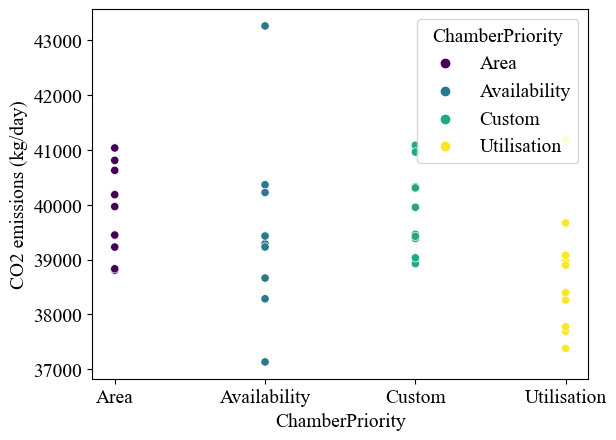

In [10]:
for i, fleet_mix in enumerate(['IMA_AlternativeFleetMix']):
    g = sns.scatterplot(experiments.loc[experiments['FleetMix']==fleet_mix], y= 'CO2 emissions (kg/day)', x=factor_explored, hue=factor_explored, 
                        palette= [viridis_colors[0], viridis_colors[2], viridis_colors[3], viridis_colors[-1]] )# palette= 'viridis')
    plt.show()

IMA_AlternativeFleetMix


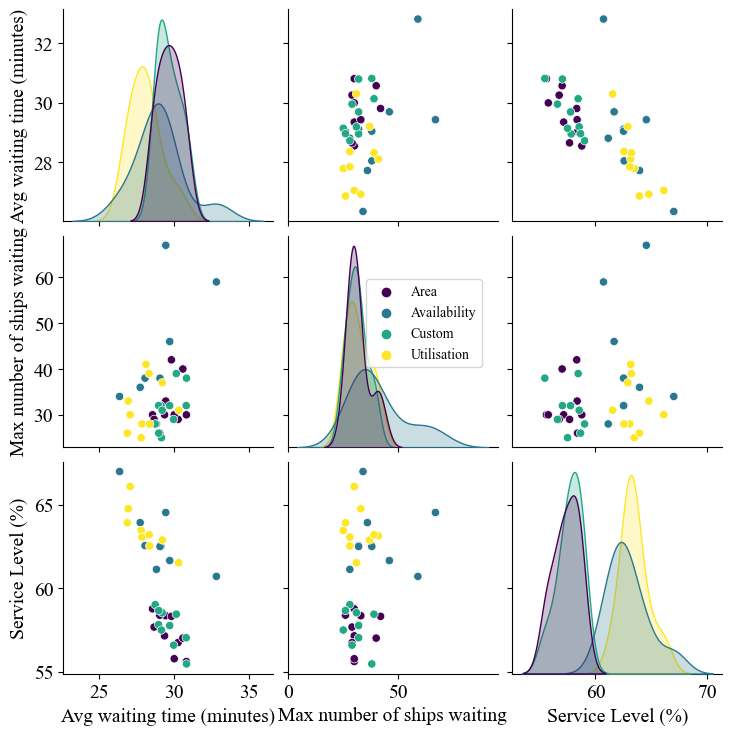

In [11]:
for i, fleet_mix in enumerate(['IMA_AlternativeFleetMix']):
    g = sns.pairplot(experiments.loc[experiments['FleetMix']==fleet_mix, cols_waiting + [factor_explored]], hue=factor_explored, 
                        palette= [viridis_colors[0], viridis_colors[2], viridis_colors[3], viridis_colors[-1]] )# palette= 'viridis')
    print(fleet_mix)
    handles = g._legend_data.values()
    labels = g._legend_data.keys()
    g._legend.remove()
    g.fig.legend(handles=handles, labels=labels, loc=(0.5, 0.5), ncol=1, fontsize=10)
    plt.show()

In [12]:
cols_KPIs

['CO2 emissions (kg/day)',
 'Avg lockage time (minutes)',
 'Avg waiting time (minutes)',
 'Number of levelings']

In [13]:
experiments.columns

Index(['SetNo', 'TrafficRange', 'FleetIntensity', 'FlutteringProbability',
       'MTTR', 'SlowDownEffect', 'MeanSlowDownCounter', 'PeriodicInspection',
       'InspectionStart', 'InspectionDuration', 'FleetMix', 'LockingRegime',
       'ChamberPriority', 'Replication Id', 'Lock', 'Number of ships',
       'Number of levelings', 'Number of empty levelings (%)',
       'Avg Occupancy (%)', 'Max number of ships waiting',
       'Avg passage time (minutes)', 'Avg waiting time (minutes)',
       'Service Level (%)', 'Total Waiting Time (hours)',
       'Total Leveling Time (hours)', 'Avg ships per leveling',
       'Avg ships per filled leveling', 'CO2 emissions (kg/day)',
       'GlobalSetNo', 'LockCondition', 'Avg lockage time (minutes)'],
      dtype='object')

In [14]:
experiments[factor_explored].unique()

array(['Area', 'Availability', 'Custom', 'Utilisation'], dtype=object)

In [15]:
cols_KPIs

['CO2 emissions (kg/day)',
 'Avg lockage time (minutes)',
 'Avg waiting time (minutes)',
 'Number of levelings']

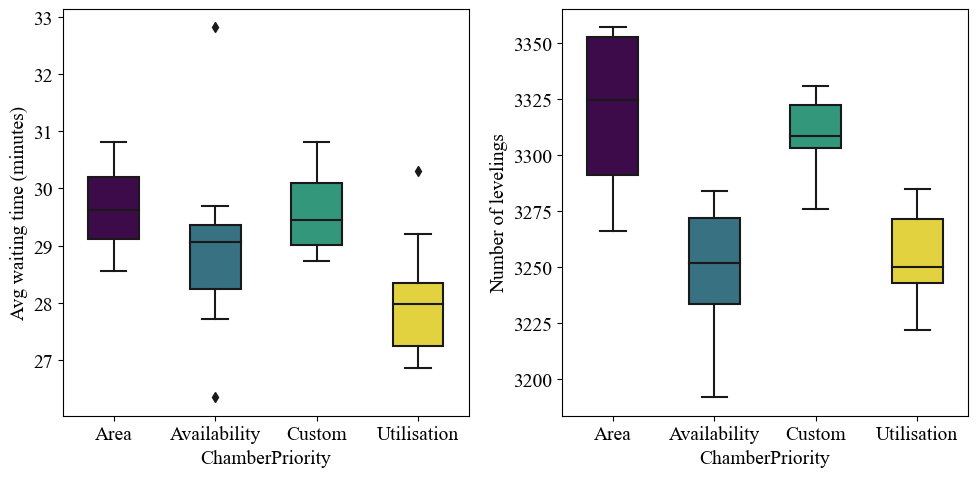

In [16]:
fig, axes = plt.subplots(1,2, figsize=(10, 5), sharey=False)
kpi_set = ['Avg waiting time (minutes)', 'Number of levelings']

for i, kpi in enumerate(kpi_set):
    sns.boxplot(ax= axes[i], y=kpi, x=factor_explored, data=experiments, 
                palette= [viridis_colors[0], viridis_colors[2], viridis_colors[3], viridis_colors[-1]], width=0.5)

plt.tight_layout()
plt.savefig('output/figs/output_analysis/univariate_experiments/' + factor_explored + '/' + str(kpi_set) + '.pdf', bbox_inches='tight')
plt.show()


In [17]:
levels = list(experiments[factor_explored].unique())
for kpi in cols_KPIs:
    print('------------------', kpi, '------------------')
    for i in range(len(levels)):
        for j in range(i+1, len(levels)):
            level1=levels[i]
            level2=levels[j]
            same_dist_hypothesis(experiments[experiments[factor_explored]==level1][kpi],
                                experiments[experiments[factor_explored]==level2][kpi],
                                level1, level2, "reject"
                                )

------------------ CO2 emissions (kg/day) ------------------
------------------ Avg lockage time (minutes) ------------------
------------------ Avg waiting time (minutes) ------------------
Reject the hypothesis that Area and Utilisation follow the same distribution
Reject the hypothesis that Custom and Utilisation follow the same distribution
------------------ Number of levelings ------------------
Reject the hypothesis that Area and Availability follow the same distribution
Reject the hypothesis that Area and Utilisation follow the same distribution
Reject the hypothesis that Availability and Custom follow the same distribution
Reject the hypothesis that Custom and Utilisation follow the same distribution


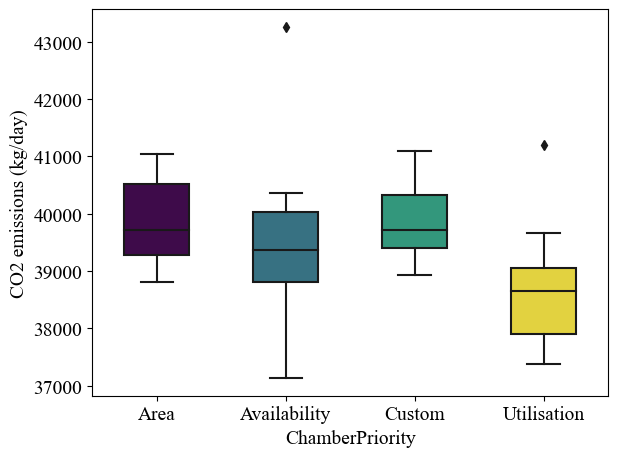

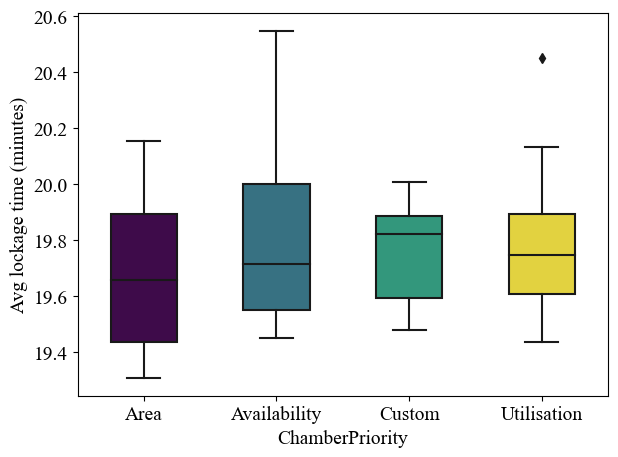

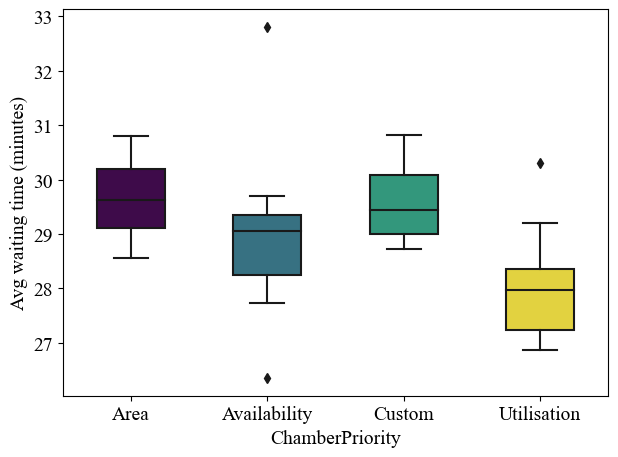

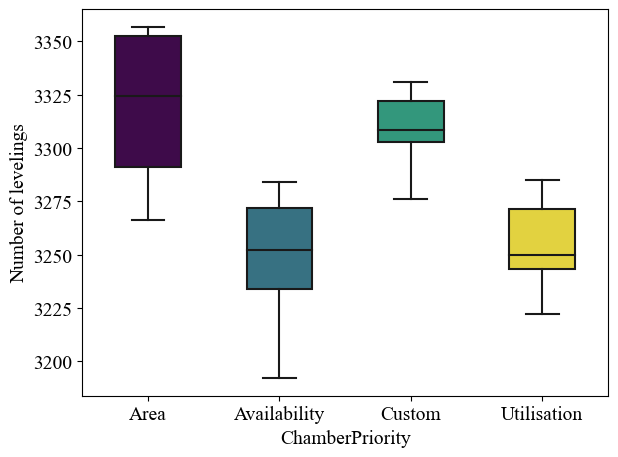

In [18]:
for kpi in cols_KPIs:
    sns.boxplot(y=kpi, x=factor_explored, data=experiments, 
                palette= [viridis_colors[0], viridis_colors[2], viridis_colors[3], viridis_colors[-1]], width=0.5)
    plt.tight_layout()
    plt.savefig('output/figs/output_analysis/univariate_experiments/' + factor_explored + '/' + kpi.replace('/', '') + '.pdf', bbox_inches='tight')
    plt.show()
